In [54]:
import pandas as pd
import numpy as np
import os
from folium import plugins
import random
import folium
from folium.features import *
from sklearn.cluster import KMeans
import networkx as nx
import collections
import matplotlib.pyplot as plt
import operator


bus = pd.read_csv('dados_bh_bus.csv')
#metro = pd.read_csv('dados_bh_metro.csv')
metro = pd.DataFrame(columns=['Name', 'lat', 'lon', 'Routes'])
train = pd.DataFrame(columns=['Name', 'lat', 'lon', 'Routes'])
other = pd.DataFrame(columns=['Name', 'lat', 'lon', 'Routes'])

#json = os.path.join('belohorizonte', 'bh.geojson')
json = ''

k = 50

seed = 0

iterations = 200

In [55]:
def createCircle(color, lat, lon):
    return(folium.Circle(
            radius=5,
            location=[lat, lon],
            color=color,
            fill=True,
            fill_opacity=0.4,
        )
    )

def locateStops(foliumMap, coordinates, color):
    for idx, row in coordinates.iterrows():
        createCircle(color, row['lat'], row['lon']).add_to(foliumMap)

        
def kMeansMap(lat, lon, color, ptsMap):
    for i in range(len(lat)):
        createCircle(color, lat[i], lon[i]).add_to(ptsMap)

        
def kMeansCentroid(lat, lon, color, i, ptsMap):
    createCentroid(color, lat, lon).add_to(ptsMap)
    createLabel(lat, lon, i).add_to(ptsMap)    
    
def createCentroid(color, lat, lon):
    return(folium.Circle(
            radius=100,
            location=[lat, lon],
            color=color,
            fill=True,
            fill_opacity=0.4,
        )
    )

def createLabel(lat, lon, i):
    return(folium.Marker(
        [lat, lon],
        icon=DivIcon(
            size=(30,36),
            anchor=(30,0),
            html=i,
            style="""
                font-size:22px;
                background-color: transparent;
                border-color: white;
                text-align: center;
                """
            )
        )
    )

class DivIcon(MacroElement):
    def __init__(self, html='', size=(30,30), anchor=(0,0), style=''):
        """TODO : docstring here"""
        super(DivIcon, self).__init__()
        self._name = 'DivIcon'
        self.size = size
        self.anchor = anchor
        self.html = html
        self.style = style

        self._template = Template(u"""
            {% macro header(this, kwargs) %}
              <style>
                .{{this.get_name()}} {
                    {{this.style}}
                    }
              </style>
            {% endmacro %}
            {% macro script(this, kwargs) %}
                var {{this.get_name()}} = L.divIcon({
                    className: '{{this.get_name()}}',
                    iconSize: [{{ this.size[0] }},{{ this.size[1] }}],
                    iconAnchor: [{{ this.anchor[0] }},{{ this.anchor[1] }}],
                    html : "{{this.html}}",
                    });
                {{this._parent.get_name()}}.setIcon({{this.get_name()}});
            {% endmacro %}
            """)

def drawEdges(points, tick):
    return (folium.PolyLine(
        points, 
        color="black", 
        weight=tick, 
        opacity=.5))

def plotDegreeRank(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histograma dos Graus dos Supernós")
    plt.ylabel("# de Supernós")
    plt.xlabel("Grau")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.savefig("DegreeRank.png", format="PNG")

In [56]:
def stopLocationMap(bus, metro, train, other, transport, json):
    locationMap = folium.Map([transport.iloc[0]['lat'], transport.iloc[0]['lon']], zoom_start=11)
    locateStops(locationMap, bus[['lat', 'lon']].drop_duplicates(), 'gray')
    locateStops(locationMap, metro[['lat', 'lon']].drop_duplicates(), 'red')
    locateStops(locationMap, train[['lat', 'lon']].drop_duplicates(), 'blue')
    locateStops(locationMap, other[['lat', 'lon']].drop_duplicates(), 'green')
    
    if(len(json) > 0):
        folium.GeoJson(json, name="City Division").add_to(locationMap)
        folium.LayerControl().add_to(locationMap)
    
    locationMap.save('locatioTESTE.html')

    
def createHeatmap(transport, json):
    heatMap = folium.Map([transport.iloc[0]['lat'], transport.iloc[0]['lon']], zoom_start=11)
    heatMap.add_child(plugins.HeatMap(transport[['lat', 'lon']].values, name='Heatmap', radius=15))

    if(len(json) > 0):
        folium.GeoJson(json, name="City Division").add_to(heatMap)
        folium.LayerControl().add_to(heatMap)
    
    heatMap.save('mapaCalor.html')
    
def graphDraw(coordinates, edges, graph_map):
    for i in coordinates.values():
        createCentroid('red', i[0], i[1]).add_to(graph_map)
    for j in edges:
        drawEdges((coordinates[j[0]], coordinates[j[1]]), j[2]).add_to(graph_map)

    
def clusterPTS(transportation, kCluster, seed, iteractions, json):
    coordinates = dict()
    pts_lines = dict()
    transportation['Routes'] = transportation['Routes'].astype(str)
    
    kmeans = KMeans(n_clusters=kCluster, random_state=seed, max_iter=iteractions).fit(transportation[['lat', 'lon']])
    id_label=kmeans.labels_
    
    kmeansMap = folium.Map([transportation.iloc[0]['lat'], transportation.iloc[0]['lon']], tiles='cartodbpositron', zoom_start=11)
    centroidMap = folium.Map([transportation.iloc[0]['lat'], transportation.iloc[0]['lon']], tiles='cartodbpositron', zoom_start=11)
    graphMap = folium.Map([transportation.iloc[0]['lat'], transportation.iloc[0]['lon']], tiles='cartodbpositron', zoom_start=11)
    
    if(len(json) > 0):
        folium.GeoJson(json, name="City Division").add_to(kmeansMap)
        folium.LayerControl().add_to(kmeansMap)
        folium.GeoJson(json, name="City Division").add_to(centroidMap)
        folium.LayerControl().add_to(centroidMap)
    
    for i in range(kCluster):
        color = "#" + "%06x" % random.randint(0, 0xFFFFFF)
        cluster=np.where(id_label==i)[0]
        tam = len(transportation['Routes'][cluster])
        lines = []
        test = transportation
        coordinates[i] = (sum(transportation['lat'][cluster].values)/tam, sum(transportation['lon'][cluster].values)/tam)
        kMeansMap(transportation['lat'][cluster].values, transportation['lon'][cluster].values, color, kmeansMap)
        kMeansCentroid(sum(transportation['lat'][cluster].values)/tam, sum(transportation['lon'][cluster].values)/tam, color, i, centroidMap)
        for j in transportation['Routes'][cluster]:
            lines = lines + j.split(',')
        pts_lines[i] = set(lines)
        
    kmeansMap.save('testeKMEANS.html')
    centroidMap.save('testeCENTROID.html')

    edges = []
    for i in range(kCluster):
        for j in range(i+1, kCluster):
            tam = len(pts_lines[i].intersection(pts_lines[j]))
            if( tam > 0 ):
                edges.append((i, j, tam))
    
    G=nx.Graph()
    for i in range(kCluster):
        G.add_node(i)
    G.add_weighted_edges_from(edges)
    
    
    print('Graus dos Nós')
    print(nx.degree(G))
    # Average Degree
    print("\n")
    print('Informação dos Nós')
    print(nx.info(G))
    # Average Path Length
    print("\n")
    if(nx.is_connected(G)):
        print('Tamanho de Caminho Médio')
        print(nx.average_shortest_path_length(G))
    else:
        print('Grafo é Disconexo')
        print("\n")
        print('Número de Componentes Conectados')
        print(nx.number_connected_components(G))
    # Betweness Centrality
    print("\n")
    print('Coeficiente de Centralidade - Betweenneess')
    print(sorted(nx.betweenness_centrality(G).items(), key=operator.itemgetter(1)))
    # Closeness Centrality
    print("\n")
    print('Coeficiente de Centralidade - Closeness')
    print(sorted(nx.closeness_centrality(G).items(), key=operator.itemgetter(1)))
    
    graphDraw(coordinates, edges, graphMap)
    
    graphMap.save('testeGRAPH.html')
    
    plotDegreeRank(G)

In [57]:
def main(bus, metro, train, other, json, cluster, seed, iteractions):
    bus.dropna(inplace=True)
    metro.dropna(inplace=True)
    train.dropna(inplace=True)
    other.dropna(inplace=True)

    transport = pd.concat([bus, metro, train, other], sort=True)
    transport.reset_index(drop=True, inplace=True)
    stopLocationMap(bus, metro, train, other, transport, json)
    
    createHeatmap(transport, json)
    
    clusterPTS(transport, cluster, seed, iteractions, json)
        
    pass

Graus dos Nós
[(0, 13), (1, 40), (2, 33), (3, 5), (4, 32), (5, 14), (6, 28), (7, 30), (8, 34), (9, 31), (10, 13), (11, 39), (12, 34), (13, 21), (14, 24), (15, 24), (16, 27), (17, 6), (18, 31), (19, 28), (20, 37), (21, 35), (22, 29), (23, 3), (24, 25), (25, 41), (26, 15), (27, 17), (28, 36), (29, 18), (30, 45), (31, 38), (32, 29), (33, 38), (34, 38), (35, 26), (36, 23), (37, 37), (38, 10), (39, 27), (40, 30), (41, 30), (42, 4), (43, 23), (44, 23), (45, 16), (46, 39), (47, 34), (48, 29), (49, 14)]


Informação dos Nós
Name: 
Type: Graph
Number of nodes: 50
Number of edges: 658
Average degree:  26.3200


Tamanho de Caminho Médio
1.502857142857143


Coeficiente de Centralidade - Betweenneess
[(17, 0.0), (23, 0.0), (42, 0.0), (49, 3.270538984824699e-05), (3, 0.00020347424684159375), (45, 0.0004380370569280344), (38, 0.001275510204081633), (5, 0.0018328028028979707), (13, 0.001994597725797814), (14, 0.0028776408043375127), (27, 0.0031024066917912994), (29, 0.003376754377022906), (43, 0.00373

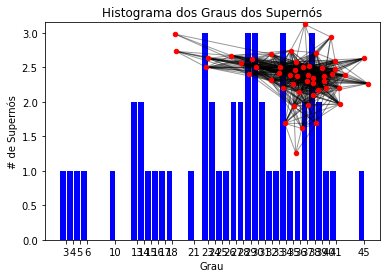

In [58]:
main(bus, metro, train, other, json, k, seed, iterations)